### CASE 1 Visualize the Experiment Result

In [1]:
from cornac.experiment.experiment_explainers import Experiment_Explainers
from cornac.datasets.goodreads import prepare_data
from cornac.datasets import goodreads
from cornac.metrics_explainer import Metric_Exp_DIV as DIV, Metric_Exp_FPR as FPR, Metric_Exp_FA as FA, Metric_Exp_RA as RA
from cornac.models import EFM, MTER
from cornac.models import ALS, MF, EMF, NEMF

from cornac.explainer import Exp_EFM, Exp_MTER
from cornac.explainer import Exp_ALS as ALSExplainer, Exp_PHI4MF as PHI4MFExplainer, Exp_SU4EMF as EMFExplainer

from cornac.experiment import Visualization
from cornac.utils import cache
import warnings
warnings.filterwarnings('ignore')

/Users/yyz/miniconda3/envs/rose_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rs_sent_dense = prepare_data(data_name="goodreads", test_size=0, dense=True, item=True, user=True, sample_size=1, seed=21)
fdiv = DIV()
fpr = FPR()
ground_truth_good_reads = goodreads.load_sentiment()
fpr_with_input_as_groundtruth = FPR(ground_truth=ground_truth_good_reads)
efm = EFM(max_iter=20, num_explicit_factors=50, num_latent_factors=50, num_most_cared_aspects=50, alpha=0.85,lambda_h=0.1, lambda_u=0.001, lambda_v=0.01, lambda_x=1.0, lambda_y= 0.1)
efm_exp = Exp_EFM(rec_model=efm, dataset=rs_sent_dense.train_set)
mter = MTER(max_iter=20, n_aspect_factors=8, n_item_factors=5, n_opinion_factors= 5, n_user_factors= 10, lambda_bpr=10, lambda_reg= 10, n_bpr_samples=1000, n_element_samples=50)
mter_exp = Exp_MTER(rec_model=mter, dataset=rs_sent_dense.train_set)

rs_dense = prepare_data(data_name="goodreads_uir_1000", test_size=0, dense=True, item=True, user=True, sample_size=1, seed=21)
emf = EMF(k=10, max_iter=500, learning_rate=0.001, lambda_reg=0.1, explain_reg=0.01, verbose=True, seed=6, num_threads=6, early_stop=True)
nemf = NEMF(k=10, max_iter=500, learning_rate=0.001, lambda_reg=0.1, explain_reg=0.01, novel_reg=1, verbose=True, seed=6, num_threads=6, early_stop=True)
als = ALS(k=10, max_iter=500, lambda_reg=0.001, alpha=1, verbose=True, seed=6)
als_exp = ALSExplainer(rec_model=als, dataset=rs_dense.train_set)
emf_exp = EMFExplainer(rec_model=emf, dataset=rs_dense.train_set)
nemf_exp = EMFExplainer(rec_model=nemf, dataset=rs_dense.train_set)

# models = [(als, als_exp), (emf, emf_exp), (nemf, nemf_exp)]
models = [(als, als_exp)]
metrics = [fdiv]
experiment = Experiment_Explainers(eval_method=rs_dense, models=models, metrics=metrics,rec_k=10, feature_k=10, eval_train=True)
experiment.run()

models = [(efm, efm_exp), (mter, mter_exp)]
metrics = [fdiv, fpr_with_input_as_groundtruth]
experiment_sent = Experiment_Explainers(eval_method=rs_sent_dense, models=models, metrics=metrics,rec_k=10, feature_k=10, eval_train=True)
experiment_sent.run()

Start training Recommender ALS...


100%|██████████| 500/500 [00:01<00:00, 412.79it/s, loss=0.0285]
INFO:implicit:Final training loss 0.0285


*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
Step 1/3: Recommender ALS creates recommendations
Step 2/3: Explainer Exp_ALS create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:02<00:00, 391.16it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.14297277277254772
experiment data: [[0.14297277277254772, 1.3341701030731201, 3.5131237506866455]]


recommender:explainer |      Metric_Exp_DIV |           Train(s) |        Evaluate(s)
ALS:Exp_ALS           | 0.14297277277254772 | 1.3341701030731201 | 3.5131237506866455

Start training Recommender EFM...
*****Start evaluating model-explainer: 'EFM:Exp_EFM'...
Step 1/3: Recommender EFM creates recommendations
Step 2/3: Explainer Exp_EFM create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 6656.90it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.5404070737401916
Step 3/3: Metric Metric_Exp_FPR starts evaluation...


Start evaluation... :   0%|          | 0/9000 [00:00<?, ?it/s]


Result: Feature Precision: 0.3761041376104137; Feature Recall: 0.06136402478469097; Harmonic Mean: 0.09628671341852728
Start training Recommender MTER...
*****Start evaluating model-explainer: 'MTER:Exp_MTER'...
Step 1/3: Recommender MTER creates recommendations
Step 2/3: Explainer Exp_MTER create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 7271.35it/s]

Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.10689089089102559


Step 3/3: Metric Metric_Exp_FPR starts evaluation...


Start evaluation... :  50%|████▉     | 55/111 [00:00<00:00, 3490.70it/s]

Result: Feature Precision: 0.4912280701754386; Feature Recall: 0.2868963406298738; Harmonic Mean: 0.30151580136191564
experiment data: [[0.5404070737401916, 0.09628671341852728, 0.05613994598388672, 2.965444803237915], [0.10689089089102559, 0.30151580136191564, 0.08958268165588379, 1.0363500118255615]]


recommender:explainer |      Metric_Exp_DIV |      Metric_Exp_FPR |            Train(s) |        Evaluate(s)
EFM:Exp_EFM           |  0.5404070737401916 | 0.09628671341852728 | 0.05613994598388672 |  2.965444803237915
MTER:Exp_MTER         | 0.10689089089102559 | 0.30151580136191564 | 0.08958268165588379 | 1.0363500118255615



Plot the bar chart for the metrics:


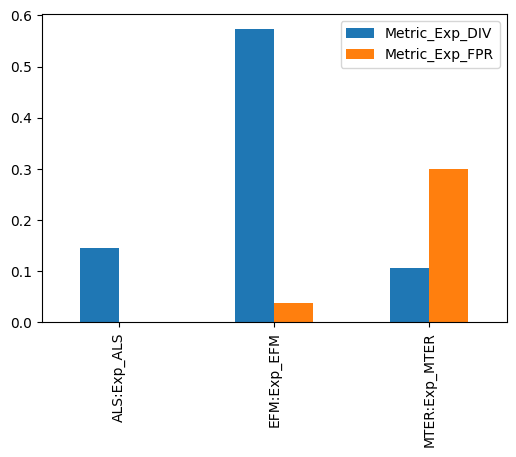

               Metric_Exp_DIV  Metric_Exp_FPR
ALS:Exp_ALS          0.145705        0.000000
EFM:Exp_EFM          0.573240        0.037523
MTER:Exp_MTER        0.105535        0.298887
Plot the bar chart for the cost:


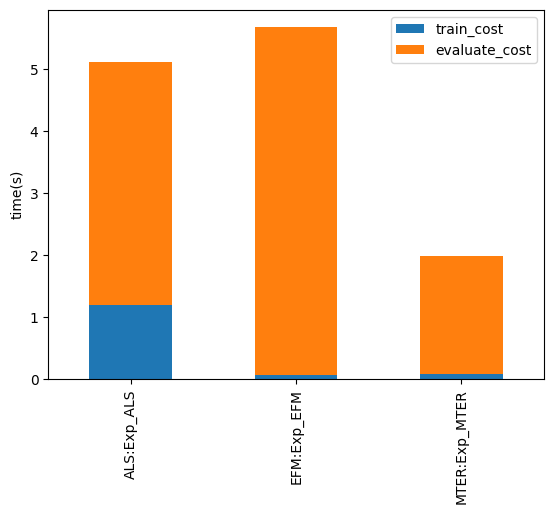

In [4]:
vis = Visualization()
vis.visualize_experiemnt_result([experiment, experiment_sent], kind="bar")

### CASE 2 Visualize the Effect of Parameters' Change (rec_k, feature_k)
Problem:
    - Explainaer_Experiment(models = [model_1, model_2], rec_k=10, feature_k = 10) fixed parameter for all models/explainers 
Solution:
    - Pass a list of Explainer_Experiment Object to func Visualization_Parameter_Change([EE_1, EE_2, EE_3], param_name = 'rec_k/feature_k')

##### 2.1 Metrics FDIV&FPR on the sentiment-related model & explainers vs feature_k

In [5]:
from cornac.metrics_explainer.exp_experiment import Explainers_Experiment
from cornac.datasets.goodreads import prepare_data
from cornac.metrics_explainer import Metric_Exp_DIV as DIV, Metric_Exp_FPR as FPR, Metric_Exp_FA as FA, Metric_Exp_RA as RA
from cornac.models import EFM, MTER
from cornac.models import ALS, MF, EMF, NEMF

from cornac.explainer import Exp_EFM, Exp_MTER
from cornac.explainer import Exp_ALS as ALSExplainer, Exp_PHI4MF as PHI4MFExplainer, Exp_SU4EMF as EMFExplainer

from cornac.experiment import Visualization
from cornac.utils import cache
import warnings
warnings.filterwarnings('ignore')

In [12]:
feature_k_list = [i for i in range(5, 11)]
rs_sent_dense = prepare_data(data_name="goodreads", test_size=0, dense=True, item=True, user=True, sample_size=1, seed=21)
fdiv = DIV()
fpr = FPR()
ground_truth_good_reads = goodreads.load_sentiment()
fpr_with_input_as_groundtruth = FPR(ground_truth=ground_truth_good_reads)
efm = EFM(max_iter=20, num_explicit_factors=50, num_latent_factors=50, num_most_cared_aspects=50, alpha=0.85,lambda_h=0.1, lambda_u=0.001, lambda_v=0.01, lambda_x=1.0, lambda_y= 0.1)
efm_exp = Exp_EFM(rec_model=efm, dataset=rs_sent_dense.train_set)

mter = MTER(max_iter=20, n_aspect_factors=8, n_item_factors=5, n_opinion_factors= 5, n_user_factors= 10, lambda_bpr=10, lambda_reg= 10, n_bpr_samples=1000, n_element_samples=50)
mter_exp = Exp_MTER(rec_model=mter, dataset=rs_sent_dense.train_set)

models = [(efm, efm_exp), (mter, mter_exp)]
metrics = [fdiv, fpr_with_input_as_groundtruth]

### To visualize the effect of increasing the number of features, we can run the experiment for different values of feature_k
EE_list = []
for feature_k in feature_k_list:
    experiment_sent = Explainers_Experiment(eval_method=rs_sent_dense, models=models, metrics=metrics,rec_k=10, feature_k=feature_k, eval_train=True)
    experiment_sent.run()
    EE_list.append(experiment_sent)


Start training Recommender EFM...
*****Start evaluating model-explainer: 'EFM:Exp_EFM'...
Step 1/3: Recommender EFM creates recommendations
Step 2/3: Explainer Exp_EFM create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 2563.06it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.4878878878875427
Step 3/3: Metric Metric_Exp_FPR starts evaluation...


Start evaluation... :  10%|█         | 900/9000 [00:04<00:44, 182.30it/s] 


Result: Feature Precision: 0.3451635351426583; Feature Recall: 0.01945615107268339; Harmonic Mean: 0.036105155076270386
Start training Recommender MTER...
*****Start evaluating model-explainer: 'MTER:Exp_MTER'...
Step 1/3: Recommender MTER creates recommendations
Step 2/3: Explainer Exp_MTER create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 3831.11it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.09641174507843737
Step 3/3: Metric Metric_Exp_FPR starts evaluation...


Start evaluation... :  30%|██▉       | 177/594 [00:00<00:00, 1162.12it/s]


Result: Feature Precision: 0.45652173913043476; Feature Recall: 0.29816792427295596; Harmonic Mean: 0.3032734012075907
experiment data: [[0.4878878878875427, 0.036105155076270386, 0.06863784790039062, 7.879937171936035], [0.09641174507843737, 0.3032734012075907, 0.08208084106445312, 1.9210989475250244]]


recommender:explainer |      Metric_Exp_DIV |       Metric_Exp_FPR |            Train(s) |        Evaluate(s)
EFM:Exp_EFM           |  0.4878878878875427 | 0.036105155076270386 | 0.06863784790039062 |  7.879937171936035
MTER:Exp_MTER         | 0.09641174507843737 |   0.3032734012075907 | 0.08208084106445312 | 1.9210989475250244

Start training Recommender EFM...
*****Start evaluating model-explainer: 'EFM:Exp_EFM'...
Step 1/3: Recommender EFM creates recommendations
Step 2/3: Explainer Exp_EFM create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 2656.48it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.3223890557223261
Step 3/3: Metric Metric_Exp_FPR starts evaluation...


Start evaluation... :  20%|██        | 1800/9000 [00:02<00:11, 618.78it/s]


Result: Feature Precision: 0.4027487821851078; Feature Recall: 0.02167022343199575; Harmonic Mean: 0.040326192529557825
Start training Recommender MTER...
*****Start evaluating model-explainer: 'MTER:Exp_MTER'...
Step 1/3: Recommender MTER creates recommendations
Step 2/3: Explainer Exp_MTER create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 3792.58it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.11949282615956655
Step 3/3: Metric Metric_Exp_FPR starts evaluation...


Start evaluation... :  10%|▉         | 59/594 [00:00<00:01, 396.37it/s]


Result: Feature Precision: 0.44549763033175355; Feature Recall: 0.2755747821544948; Harmonic Mean: 0.2873748742147778
experiment data: [[0.3223890557223261, 0.040326192529557825, 0.07137203216552734, 5.834213018417358], [0.11949282615956655, 0.2873748742147778, 0.08668899536132812, 1.8763141632080078]]


recommender:explainer |      Metric_Exp_DIV |       Metric_Exp_FPR |            Train(s) |        Evaluate(s)
EFM:Exp_EFM           |  0.3223890557223261 | 0.040326192529557825 | 0.07137203216552734 |  5.834213018417358
MTER:Exp_MTER         | 0.11949282615956655 |   0.2873748742147778 | 0.08668899536132812 | 1.8763141632080078

Start training Recommender EFM...
*****Start evaluating model-explainer: 'EFM:Exp_EFM'...
Step 1/3: Recommender EFM creates recommendations
Step 2/3: Explainer Exp_EFM create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 1720.41it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.18251584918230745
Step 3/3: Metric Metric_Exp_FPR starts evaluation...


Start evaluation... :  40%|████      | 3600/9000 [00:02<00:03, 1362.74it/s]


Result: Feature Precision: 0.42968142968142964; Feature Recall: 0.023098627184057818; Harmonic Mean: 0.04275836601364876
Start training Recommender MTER...
*****Start evaluating model-explainer: 'MTER:Exp_MTER'...
Step 1/3: Recommender MTER creates recommendations
Step 2/3: Explainer Exp_MTER create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 3756.82it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.10380847514183016
Step 3/3: Metric Metric_Exp_FPR starts evaluation...


Start evaluation... :  10%|▉         | 59/594 [00:00<00:01, 385.65it/s]


Result: Feature Precision: 0.4799999999999999; Feature Recall: 0.27392207543930686; Harmonic Mean: 0.29795528911981606
experiment data: [[0.18251584918230745, 0.04275836601364876, 0.07087326049804688, 5.729848861694336], [0.10380847514183016, 0.29795528911981606, 0.08990693092346191, 2.0747509002685547]]


recommender:explainer |      Metric_Exp_DIV |      Metric_Exp_FPR |            Train(s) |        Evaluate(s)
EFM:Exp_EFM           | 0.18251584918230745 | 0.04275836601364876 | 0.07087326049804688 |  5.729848861694336
MTER:Exp_MTER         | 0.10380847514183016 | 0.29795528911981606 | 0.08990693092346191 | 2.0747509002685547

Start training Recommender EFM...
*****Start evaluating model-explainer: 'EFM:Exp_EFM'...
Step 1/3: Recommender EFM creates recommendations
Step 2/3: Explainer Exp_EFM create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 2368.33it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.12005338672022971
Step 3/3: Metric Metric_Exp_FPR starts evaluation...


Start evaluation... :  50%|█████     | 4500/9000 [00:02<00:02, 1782.89it/s]


Result: Feature Precision: 0.45817805383022775; Feature Recall: 0.024494419810917; Harmonic Mean: 0.045318569129367464
Start training Recommender MTER...
*****Start evaluating model-explainer: 'MTER:Exp_MTER'...
Step 1/3: Recommender MTER creates recommendations
Step 2/3: Explainer Exp_MTER create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 3721.02it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.11847914581254082
Step 3/3: Metric Metric_Exp_FPR starts evaluation...


Start evaluation... :  30%|██▉       | 177/594 [00:00<00:00, 1150.85it/s]


Result: Feature Precision: 0.4504950495049505; Feature Recall: 0.28258706238009007; Harmonic Mean: 0.29291462257612305
experiment data: [[0.12005338672022971, 0.045318569129367464, 0.07092595100402832, 5.539509057998657], [0.11847914581254082, 0.29291462257612305, 0.0759267807006836, 1.880126953125]]


recommender:explainer |      Metric_Exp_DIV |       Metric_Exp_FPR |            Train(s) |       Evaluate(s)
EFM:Exp_EFM           | 0.12005338672022971 | 0.045318569129367464 | 0.07092595100402832 | 5.539509057998657
MTER:Exp_MTER         | 0.11847914581254082 |  0.29291462257612305 |  0.0759267807006836 |    1.880126953125

Start training Recommender EFM...
*****Start evaluating model-explainer: 'EFM:Exp_EFM'...
Step 1/3: Recommender EFM creates recommendations
Step 2/3: Explainer Exp_EFM create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 2312.95it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.10377043710389003
Step 3/3: Metric Metric_Exp_FPR starts evaluation...


Start evaluation... :  50%|█████     | 4500/9000 [00:04<00:04, 1024.74it/s]


Result: Feature Precision: 0.491015625; Feature Recall: 0.025681901482793264; Harmonic Mean: 0.047677800702258334
Start training Recommender MTER...
*****Start evaluating model-explainer: 'MTER:Exp_MTER'...
Step 1/3: Recommender MTER creates recommendations
Step 2/3: Explainer Exp_MTER create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 3690.58it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.0904738071404737
Step 3/3: Metric Metric_Exp_FPR starts evaluation...


Start evaluation... :  30%|██▉       | 177/594 [00:00<00:00, 1180.58it/s]


Result: Feature Precision: 0.46116504854368934; Feature Recall: 0.2683892600025021; Harmonic Mean: 0.2915803179111382
experiment data: [[0.10377043710389003, 0.047677800702258334, 0.07053208351135254, 7.495198011398315], [0.0904738071404737, 0.2915803179111382, 0.07728290557861328, 1.886641025543213]]


recommender:explainer |      Metric_Exp_DIV |       Metric_Exp_FPR |            Train(s) |       Evaluate(s)
EFM:Exp_EFM           | 0.10377043710389003 | 0.047677800702258334 | 0.07053208351135254 | 7.495198011398315
MTER:Exp_MTER         |  0.0904738071404737 |   0.2915803179111382 | 0.07728290557861328 | 1.886641025543213

Start training Recommender EFM...
*****Start evaluating model-explainer: 'EFM:Exp_EFM'...
Step 1/3: Recommender EFM creates recommendations
Step 2/3: Explainer Exp_EFM create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 2299.39it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.08568568568570036
Step 3/3: Metric Metric_Exp_FPR starts evaluation...


Start evaluation... :  60%|██████    | 5400/9000 [00:02<00:01, 2098.78it/s]


Result: Feature Precision: 0.5062985332182917; Feature Recall: 0.026498555849340848; Harmonic Mean: 0.04922721281900498
Start training Recommender MTER...
*****Start evaluating model-explainer: 'MTER:Exp_MTER'...
Step 1/3: Recommender MTER creates recommendations
Step 2/3: Explainer Exp_MTER create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 3770.41it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.09617951284618784
Step 3/3: Metric Metric_Exp_FPR starts evaluation...


Start evaluation... :  20%|█▉        | 118/594 [00:00<00:00, 792.87it/s]


Result: Feature Precision: 0.45789473684210524; Feature Recall: 0.2804030877578646; Harmonic Mean: 0.2980780009296637
experiment data: [[0.08568568568570036, 0.04922721281900498, 0.07098078727722168, 5.575579881668091], [0.09617951284618784, 0.2980780009296637, 0.08325624465942383, 1.8821287155151367]]


recommender:explainer |      Metric_Exp_DIV |      Metric_Exp_FPR |            Train(s) |        Evaluate(s)
EFM:Exp_EFM           | 0.08568568568570036 | 0.04922721281900498 | 0.07098078727722168 |  5.575579881668091
MTER:Exp_MTER         | 0.09617951284618784 |  0.2980780009296637 | 0.08325624465942383 | 1.8821287155151367



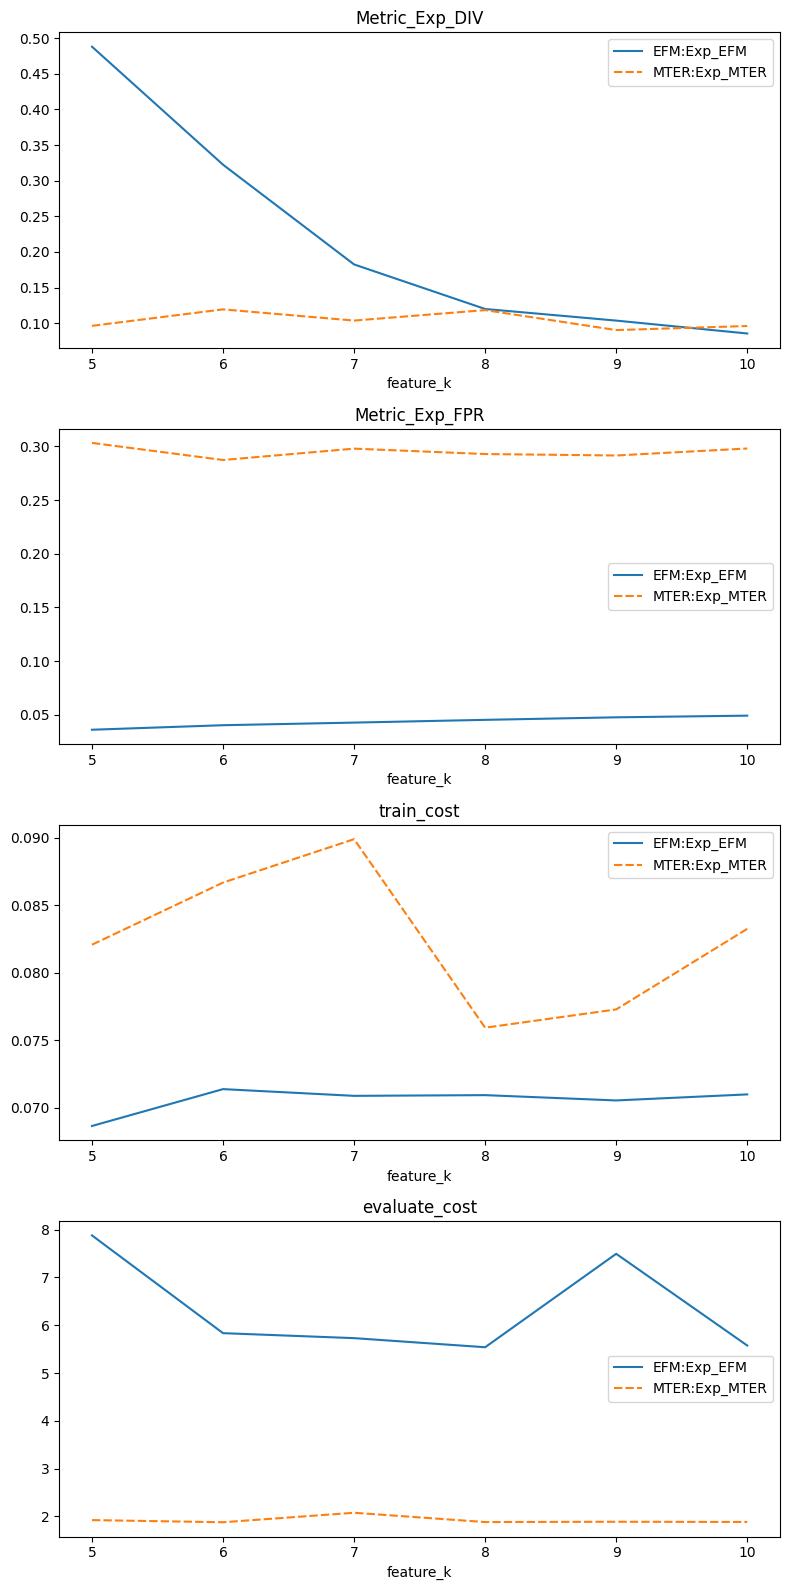

In [13]:
vis = Visualization()
vis.visualize_target_k(EE_list, target_k_name="feature_k", kind="line")

##### 2.1 Metrics FDIV on the MF models & explainers vs feature_k

In [8]:
rs_dense = prepare_data(data_name="goodreads_uir_1000", test_size=0, dense=True, item=True, user=True, sample_size=1, seed=21)
emf = EMF(k=10, max_iter=500, learning_rate=0.001, lambda_reg=0.1, explain_reg=0.01, verbose=True, seed=6, num_threads=6, early_stop=True)
nemf = NEMF(k=10, max_iter=500, learning_rate=0.001, lambda_reg=0.1, explain_reg=0.01, novel_reg=1, verbose=True, seed=6, num_threads=6, early_stop=True)
als = ALS(k=10, max_iter=500, lambda_reg=0.001, alpha=1, verbose=True, seed=6)
als_exp = ALSExplainer(rec_model=als, dataset=rs_dense.train_set)
emf_exp = EMFExplainer(rec_model=emf, dataset=rs_dense.train_set)
nemf_exp = EMFExplainer(rec_model=nemf, dataset=rs_dense.train_set)
fdiv = DIV()
models = [(als, als_exp), (emf, emf_exp), (nemf, nemf_exp)]
metrics = [fdiv]
experiment = Explainers_Experiment(eval_method=rs_dense, models=models, metrics=metrics,rec_k=10, feature_k=10, eval_train=True)

# feature_k_list = [i for i in range(5, 11)]
rec_k_list = [i for i in range(5, 11)]
EE_list = []
for rec_k in rec_k_list:
    experiment = Explainers_Experiment(eval_method=rs_dense, models=models, metrics=metrics,rec_k=rec_k, feature_k=10, eval_train=True)
    experiment.run()
    EE_list.append(experiment)


EMF:Exp_SU4EMF removed from list of models since the combination is not valid!
NEMF:Exp_SU4EMF removed from list of models since the combination is not valid!
EMF:Exp_SU4EMF removed from list of models since the combination is not valid!
NEMF:Exp_SU4EMF removed from list of models since the combination is not valid!
Start training Recommender ALS...


100%|██████████| 500/500 [00:00<00:00, 609.12it/s, loss=0.0285]
INFO:implicit:Final training loss 0.0285


*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
Step 1/3: Recommender ALS creates recommendations
Step 2/3: Explainer Exp_ALS create explanation for all recommendations


Computing explanations: 100%|██████████| 500/500 [00:02<00:00, 220.87it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.14574268537078613
experiment data: [[0.14574268537078613, 0.8230941295623779, 2.623591184616089]]


recommender:explainer |      Metric_Exp_DIV |           Train(s) |       Evaluate(s)
ALS:Exp_ALS           | 0.14574268537078613 | 0.8230941295623779 | 2.623591184616089

EMF:Exp_SU4EMF removed from list of models since the combination is not valid!
NEMF:Exp_SU4EMF removed from list of models since the combination is not valid!
Start training Recommender ALS...


100%|██████████| 500/500 [00:01<00:00, 497.63it/s, loss=0.0285]
INFO:implicit:Final training loss 0.0285


*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
Step 1/3: Recommender ALS creates recommendations
Step 2/3: Explainer Exp_ALS create explanation for all recommendations


Computing explanations: 100%|██████████| 600/600 [00:02<00:00, 255.63it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.14497106288250966
experiment data: [[0.14497106288250966, 1.006376028060913, 2.7935848236083984]]


recommender:explainer |      Metric_Exp_DIV |          Train(s) |        Evaluate(s)
ALS:Exp_ALS           | 0.14497106288250966 | 1.006376028060913 | 2.7935848236083984

EMF:Exp_SU4EMF removed from list of models since the combination is not valid!
NEMF:Exp_SU4EMF removed from list of models since the combination is not valid!
Start training Recommender ALS...


100%|██████████| 500/500 [00:01<00:00, 458.65it/s, loss=0.0285]
INFO:implicit:Final training loss 0.0285


*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
Step 1/3: Recommender ALS creates recommendations
Step 2/3: Explainer Exp_ALS create explanation for all recommendations


Computing explanations: 100%|██████████| 700/700 [00:02<00:00, 250.46it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.1433112609849191
experiment data: [[0.1433112609849191, 1.0921518802642822, 3.28818416595459]]


recommender:explainer |     Metric_Exp_DIV |           Train(s) |      Evaluate(s)
ALS:Exp_ALS           | 0.1433112609849191 | 1.0921518802642822 | 3.28818416595459

EMF:Exp_SU4EMF removed from list of models since the combination is not valid!
NEMF:Exp_SU4EMF removed from list of models since the combination is not valid!
Start training Recommender ALS...


100%|██████████| 500/500 [00:00<00:00, 508.83it/s, loss=0.0285]
INFO:implicit:Final training loss 0.0285


*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
Step 1/3: Recommender ALS creates recommendations
Step 2/3: Explainer Exp_ALS create explanation for all recommendations


Computing explanations: 100%|██████████| 800/800 [00:03<00:00, 265.16it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.1421195244052615
experiment data: [[0.1421195244052615, 0.9847040176391602, 3.6389780044555664]]


recommender:explainer |     Metric_Exp_DIV |           Train(s) |        Evaluate(s)
ALS:Exp_ALS           | 0.1421195244052615 | 0.9847040176391602 | 3.6389780044555664

EMF:Exp_SU4EMF removed from list of models since the combination is not valid!
NEMF:Exp_SU4EMF removed from list of models since the combination is not valid!
Start training Recommender ALS...


100%|██████████| 500/500 [00:00<00:00, 500.38it/s, loss=0.0285]
INFO:implicit:Final training loss 0.0285


*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
Step 1/3: Recommender ALS creates recommendations
Step 2/3: Explainer Exp_ALS create explanation for all recommendations


Computing explanations: 100%|██████████| 900/900 [00:03<00:00, 255.99it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.14094277592355922
experiment data: [[0.14094277592355922, 1.0008161067962646, 4.306041955947876]]


recommender:explainer |      Metric_Exp_DIV |           Train(s) |       Evaluate(s)
ALS:Exp_ALS           | 0.14094277592355922 | 1.0008161067962646 | 4.306041955947876

EMF:Exp_SU4EMF removed from list of models since the combination is not valid!
NEMF:Exp_SU4EMF removed from list of models since the combination is not valid!
Start training Recommender ALS...


100%|██████████| 500/500 [00:00<00:00, 534.78it/s, loss=0.0285]
INFO:implicit:Final training loss 0.0285


*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
Step 1/3: Recommender ALS creates recommendations
Step 2/3: Explainer Exp_ALS create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:04<00:00, 212.94it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.14058618618596413
experiment data: [[0.14058618618596413, 0.9374692440032959, 5.627757787704468]]


recommender:explainer |      Metric_Exp_DIV |           Train(s) |       Evaluate(s)
ALS:Exp_ALS           | 0.14058618618596413 | 0.9374692440032959 | 5.627757787704468



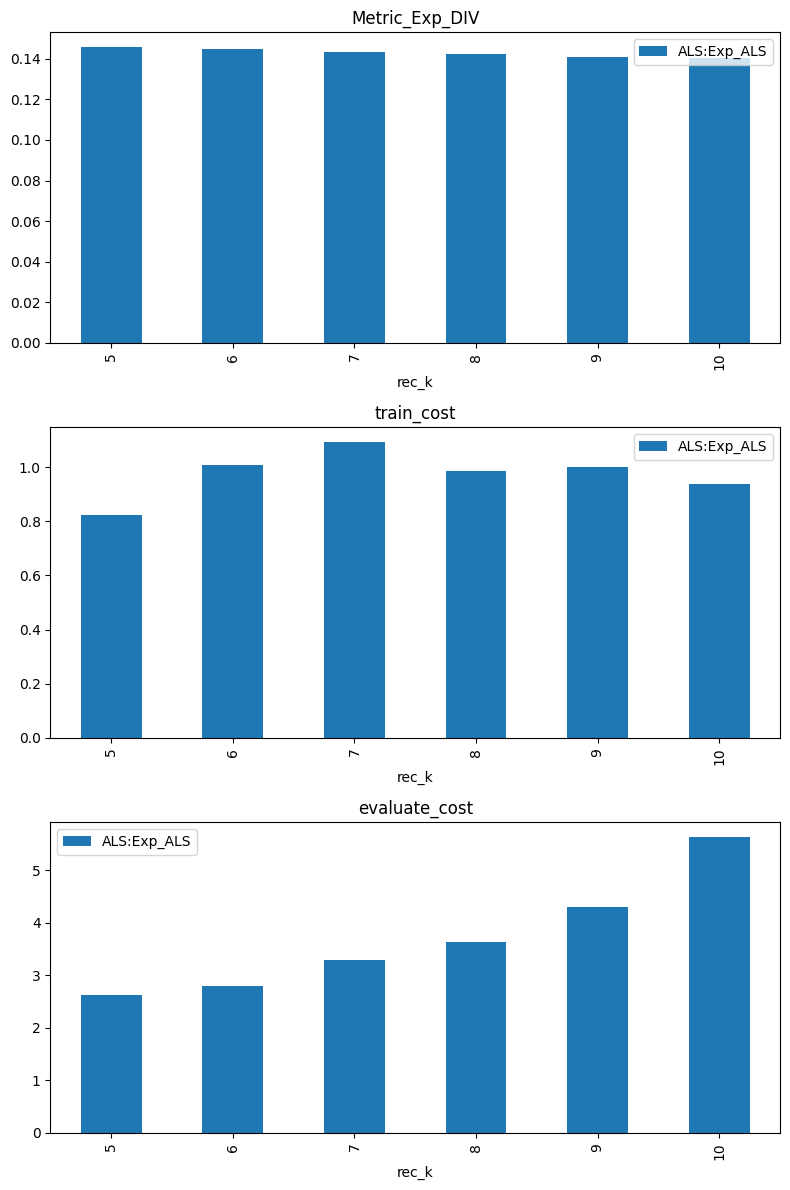

In [9]:
vis = Visualization()
vis.visualize_target_k(EE_list, target_k_name="rec_k", kind="bar")

### CASE 3 Visualize feature importance



In [1]:
import numpy as np
from cornac.models.fm_py import FMRec
from cornac.explainer.exp_limers import Exp_LIMERS
from cornac.datasets.goodreads import prepare_data
import warnings
warnings.filterwarnings('ignore')

rs = prepare_data(data_name="goodreads_limers", test_size=0.2, dense=True, item=True, user=False, sample_size=0.5, seed=21)
fm = FMRec()
fm.fit(train_set=rs.train_set)
explainer = Exp_LIMERS(fm, fm.train_set)
users = np.array(list(rs.train_set.uid_map.keys()))
items = np.array(list(rs.train_set.iid_map.keys()))
recommendations = fm.recommend_to_multiple_users(users)
explanations = explainer.explain_recommendations(recommendations)

/Users/yyz/miniconda3/envs/rose_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.89424
-- Epoch 2
Training MSE: 0.74081
-- Epoch 3
Training MSE: 0.72055
-- Epoch 4
Training MSE: 0.70196
-- Epoch 5
Training MSE: 0.69348
-- Epoch 6
Training MSE: 0.68345
-- Epoch 7
Training MSE: 0.67570
-- Epoch 8
Training MSE: 0.66859
-- Epoch 9
Training MSE: 0.66165
-- Epoch 10
Training MSE: 0.65072


Computing explanations: 100%|██████████| 10000/10000 [01:59<00:00, 83.56it/s]


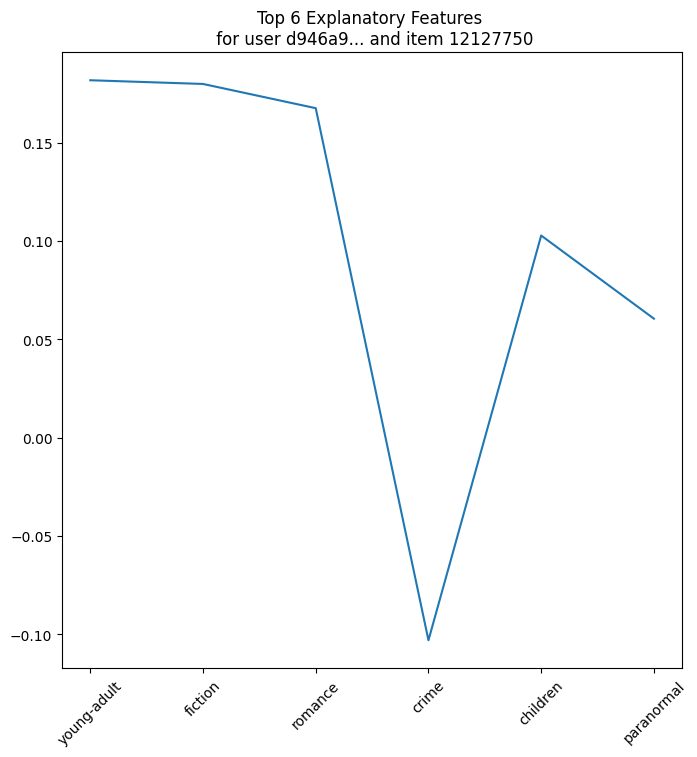

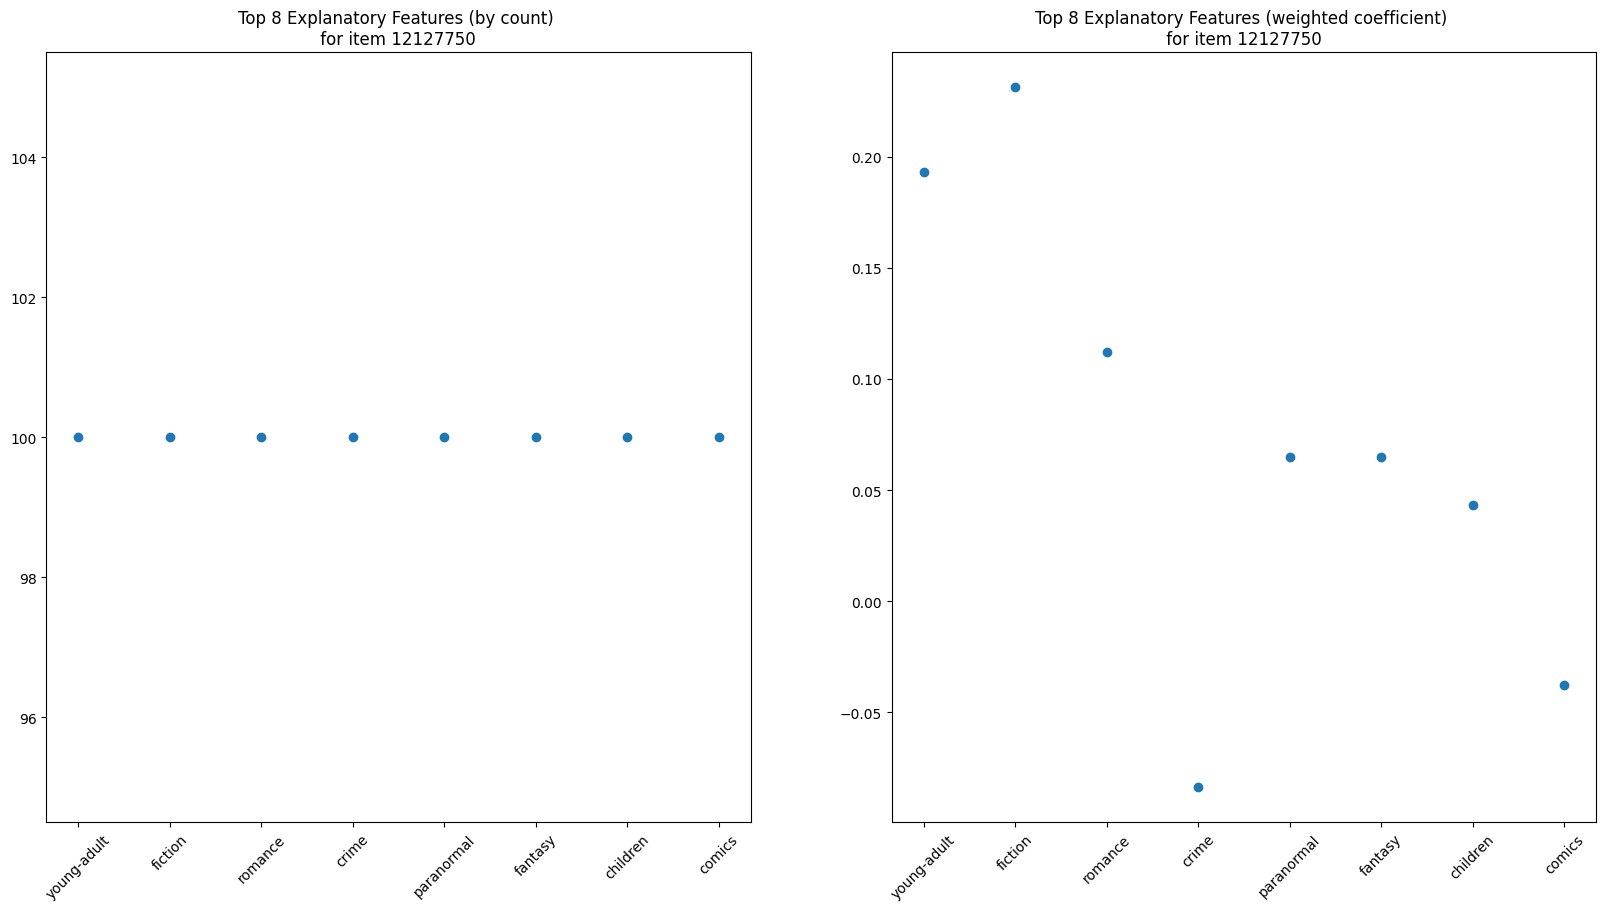

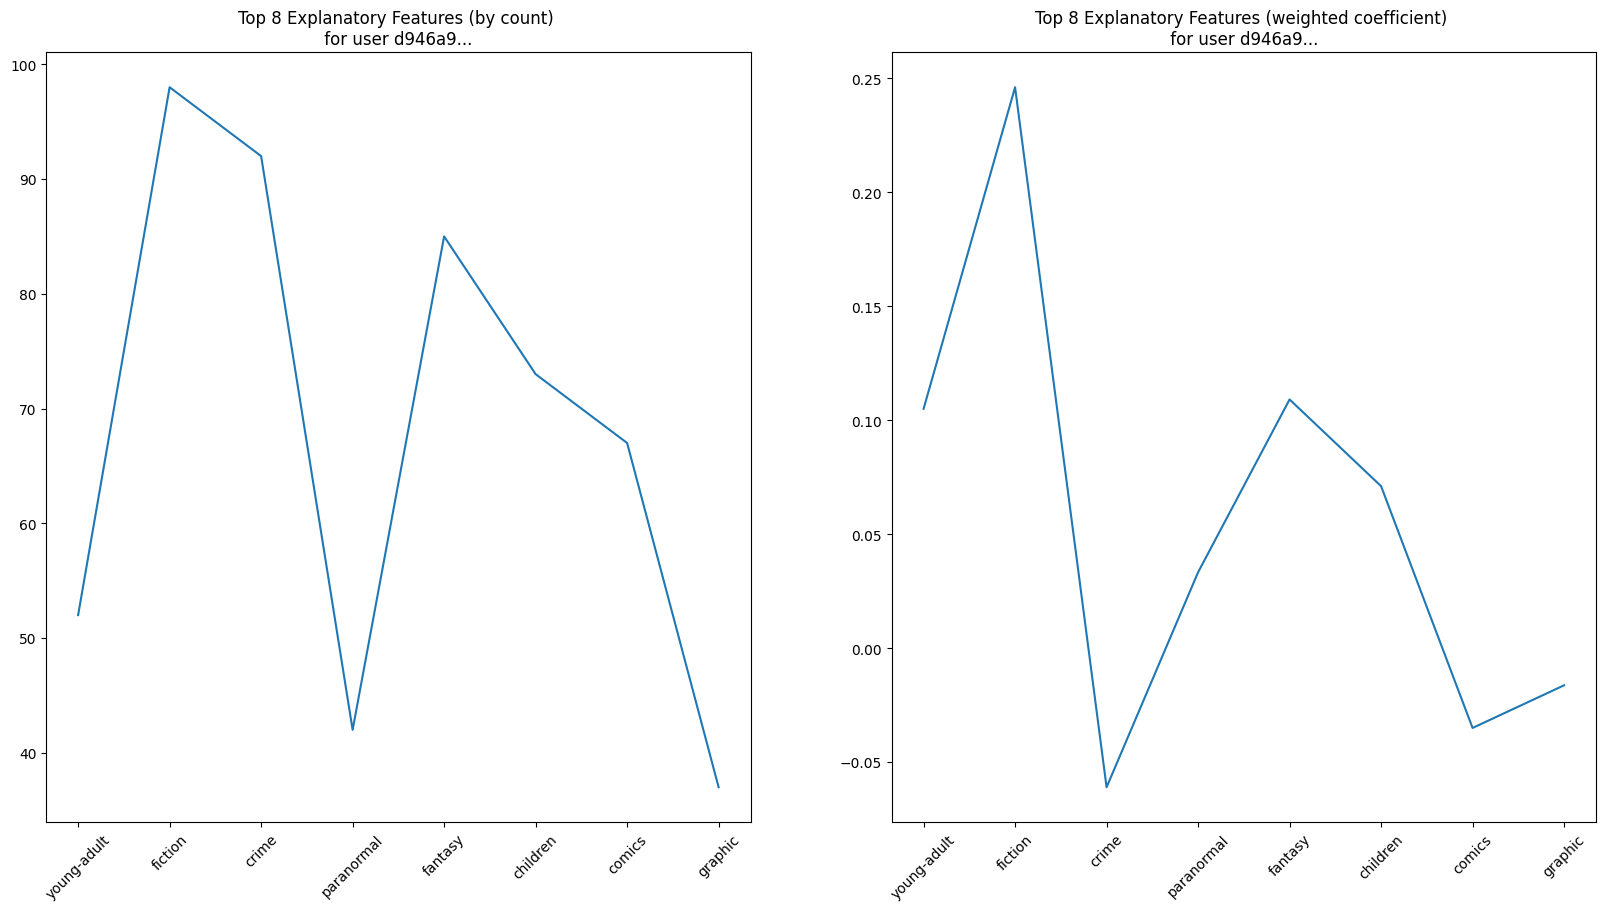

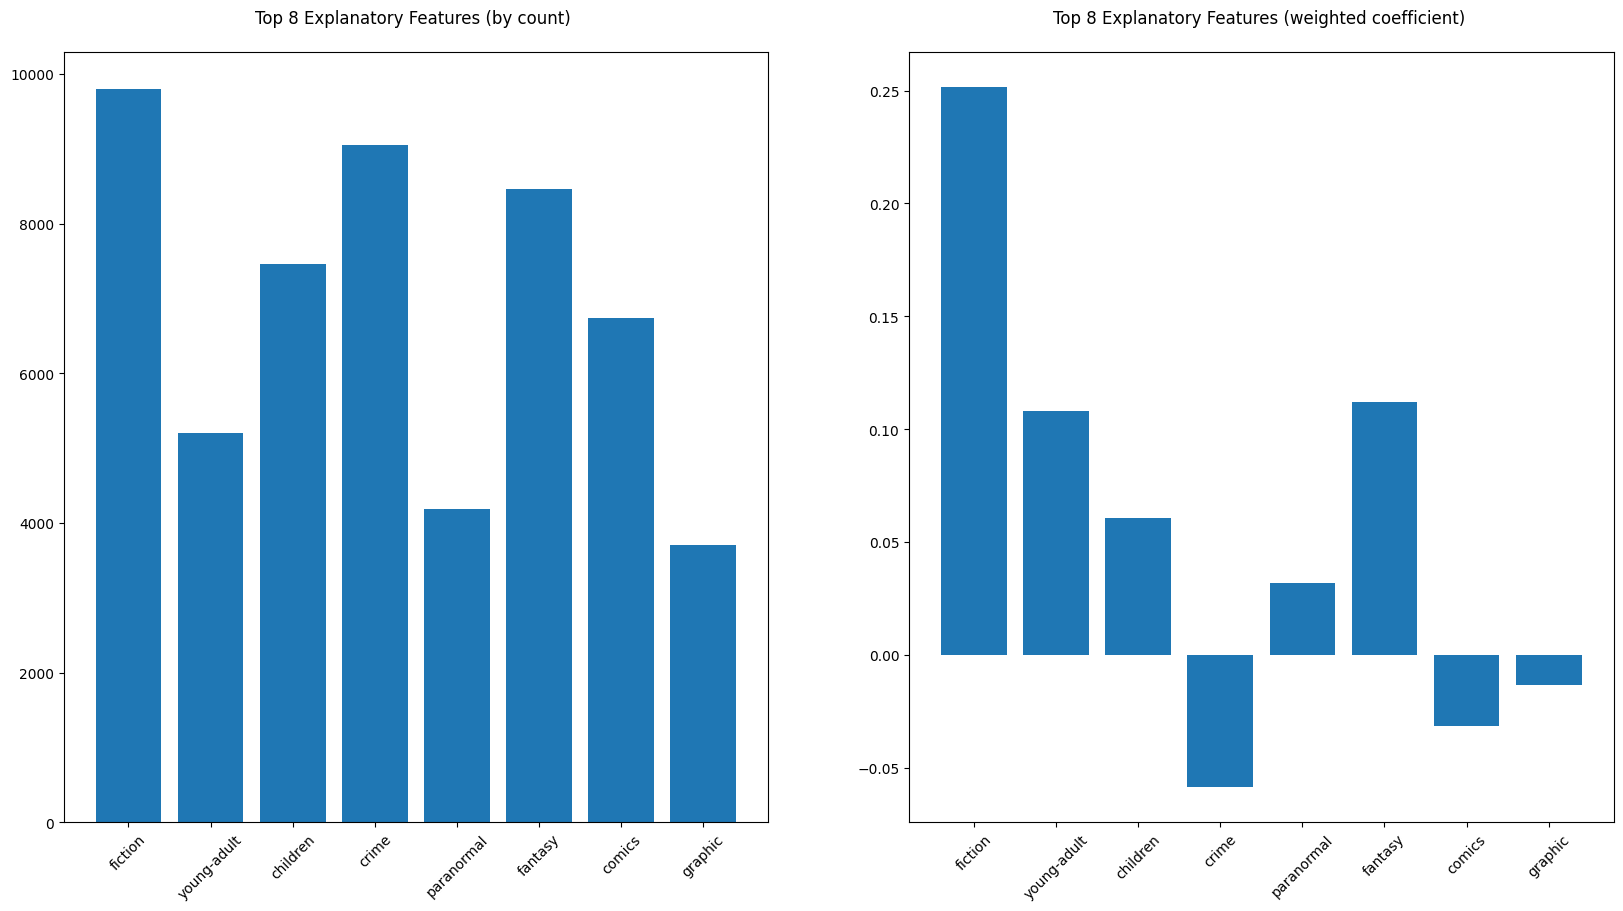

In [2]:
from cornac.experiment.visualization import Visualization

explanations_df = explanations.copy()
my_plots = Visualization()
ind_df = my_plots.create_individual_feature_importance_plot(explanations, user_id='d946a9aaa488924227a587c91564a484', item_id=12127750, type="line", top_k=6, save_plot=False)

filtered_df1 = my_plots.create_aggregate_feature_importance_plot(explanations, item_id=12127750, type="scatter", top_k=8, save_plot=False)

filtered_df2 = my_plots.create_aggregate_feature_importance_plot(explanations, user_id='d946a9aaa488924227a587c91564a484', type="line", top_k=8, save_plot=False)

filtered_df3 = my_plots.create_aggregate_feature_importance_plot(explanations, type="bar", top_k=8, save_plot=False)